## Libraries

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from math import pi
from scipy.stats import zscore
import os
from math import log10


plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', serif='lmodern')
plt.rc('font', size=12)  # Adjust the font size if needed

# Compare models together

In [7]:
# load model
model_a = {"name": "vanilla_pinn", "metric_dir": "./vanilla_pinn"}
model_b = {"name": "hyper_lr_pinn", "metric_dir": "./hyper_lr_pinn"}
inputs = []
inputs.append(model_a)
inputs.append(model_b)

## Compare Tools

In [68]:
def remove_outliers(data, factor=1.5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return np.clip(data, lower_bound, upper_bound)

def smooth(data, window_size=25):
    """Smooth the data using a moving average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_loss(inputs):
    plt.figure(figsize=(8, 6))
    colors = ["skyblue", "coral", "limegreen", "gold", "orchid"]
    
    for i, model in enumerate(inputs):
        # -- load data
        data = np.load(f"{model['name']}/metrics2target2.npz", allow_pickle=True)['arr_0'].item()
        losses = data['loss']
        losses_array = np.vstack(losses)
        
        # Remove outliers
        losses_array_clean = remove_outliers(losses_array)
        
        # Compute mean and std
        mean_loss = np.mean(losses_array_clean, axis=0)
        std_loss = np.std(losses_array_clean, axis=0)
        
        # Smooth the mean and std losses
        smoothed_mean = smooth(mean_loss, window_size=300)  # Adjust window_size as needed
        smoothed_std = smooth(std_loss, window_size=300)  # Adjust window_size as needed
        
        # Create x axis
        x = np.arange(len(mean_loss))
        x_smooth = np.arange(len(smoothed_mean))
        
        plt.plot(x_smooth, smoothed_mean, label=f"{model['name']} loss")
        plt.fill_between(x_smooth, smoothed_mean - smoothed_std, smoothed_mean + smoothed_std, color=colors[i], alpha=0.3)
    
    #plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses: Comparison of Models')
    plt.legend()
    plt.savefig("losses_log_scale_no_outliers.pdf")
    plt.show()
    
def remove_outliers_radar(data, m=2):
    if np.isscalar(data):
        return np.array([data])
    data = np.array(data)
    if data.size == 1:
        return data
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def normalize_log(value, min_val, max_val):
    if min_val == max_val:
        return 1.0
    log_min, log_max = log10(min_val), log10(max_val)
    return (log10(value) - log_min) / (log_max - log_min)

def plot_radar_chart(inputs):
    plt.figure(figsize=(8, 6))
    colors = ["skyblue", "coral", "limegreen", "gold", "orchid", "purple"]

    # Categories: replace "Time" and "Epochs" with "Time2Target" and "Epochs2Target"
    categories = ['Time2Target', 'Model Parameters', 'Collocation Points', 'Terminal Loss', 'Terminal rl2', 'Epochs2Target']
    num_vars = len(categories)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Close the circle

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)

    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)

    max_time2target, max_epochs2target = 0, 0
    max_model_params, max_collocation_points = 0, 0
    min_loss, max_loss = float('inf'), float('-inf')
    min_rmse, max_rmse = float('inf'), float('-inf')

    # First pass to get min and max values
    for model in inputs:
        data = np.load(f"{model['name']}/metrics2target2.npz", allow_pickle=True)['arr_0'].item()

        losses = data['loss']
        rmse_errors = data['rl2_error']
        model_params = data['model']
        collocation_points = data['points']
        time2target = data['time2target']
        print(np.array(time2target).mean())
        epochs2target = data['epochs2target']

        # Compute final loss and average RMSE
        if isinstance(losses, list) and losses and isinstance(losses[0], (list, np.ndarray)):
            final_loss = losses[-1][-1]
        else:
            final_loss = losses[-1] if isinstance(losses, (list, np.ndarray)) else losses

        if isinstance(rmse_errors, list) and rmse_errors and isinstance(rmse_errors[0], (list, np.ndarray)):
            avg_rmse = np.mean(rmse_errors[-1])  # Average RMSE over the last epoch
        else:
            avg_rmse = np.mean(rmse_errors) if isinstance(rmse_errors, (list, np.ndarray)) else rmse_errors

        # Update min and max values
        min_loss = min(min_loss, final_loss)
        max_loss = max(max_loss, final_loss)
        min_rmse = min(min_rmse, avg_rmse)
        max_rmse = max(max_rmse, avg_rmse)
        max_model_params = max(max_model_params, np.max(model_params))
        max_collocation_points = max(max_collocation_points, np.max(collocation_points))
        max_time2target = max(max_time2target, np.max(np.array(time2target).mean()))
        max_epochs2target = max(max_epochs2target, np.max(np.array(epochs2target).mean()))

    # Second pass to plot
    for i, model in enumerate(inputs):
        data = np.load(f"{model['name']}/metrics2target2.npz", allow_pickle=True)['arr_0'].item()

        model_params = data['model']
        collocation_points = data['points']
        losses = data['loss']
        rmse_errors = data['rl2_error']
        time2target = data['time2target']
        epochs2target = data['epochs2target']

        # Compute average RMSE
        if isinstance(rmse_errors, list) and rmse_errors and isinstance(rmse_errors[0], (list, np.ndarray)):
            avg_rmse = np.mean(rmse_errors[-1])  # Average RMSE over the last epoch
        else:
            avg_rmse = np.mean(rmse_errors) if isinstance(rmse_errors, (list, np.ndarray)) else rmse_errors

        # Normalize values
        model_params_normalized = np.mean(model_params) / max_model_params if max_model_params != 0 else 0
        collocation_points_normalized = np.mean(collocation_points) / max_collocation_points if max_collocation_points != 0 else 0
        final_loss_normalized = normalize_log(final_loss, min_loss, max_loss)
        avg_rmse_normalized = avg_rmse / max_rmse #normalize_log(avg_rmse, min_rmse, max_rmse)

        # Normalize time2target and epochs2target
        time2target_normalized = np.mean(time2target) / max_time2target 
        epochs2target_normalized = np.mean(epochs2target) / max_epochs2target 

        means = [
            time2target_normalized,  # Replacing "Time" with "Time2Target"
            model_params_normalized,
            collocation_points_normalized,
            final_loss_normalized,
            avg_rmse_normalized,
            epochs2target_normalized  # Replacing "Epochs" with "Epochs2Target"
        ]

        means += means[:1]  # Close the circle

        ax.plot(angles, means, linewidth=2, linestyle='solid', label=f"{model['name']}", color=colors[i])
        ax.fill(angles, means, color=colors[i], alpha=0.4)

    plt.title('Comparison of Model Adaptation')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    plt.savefig("radar_chart_comparison.pdf", bbox_inches='tight')
    plt.show()



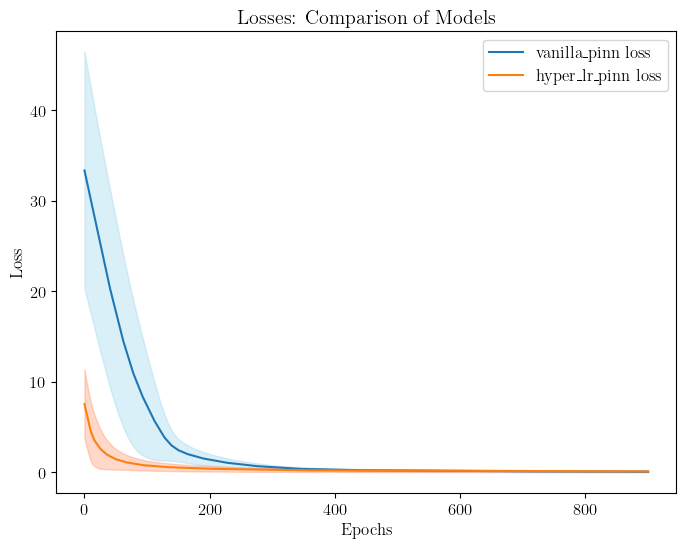

In [69]:
plot_loss(inputs)

15.163386702537537
14.229930728673935


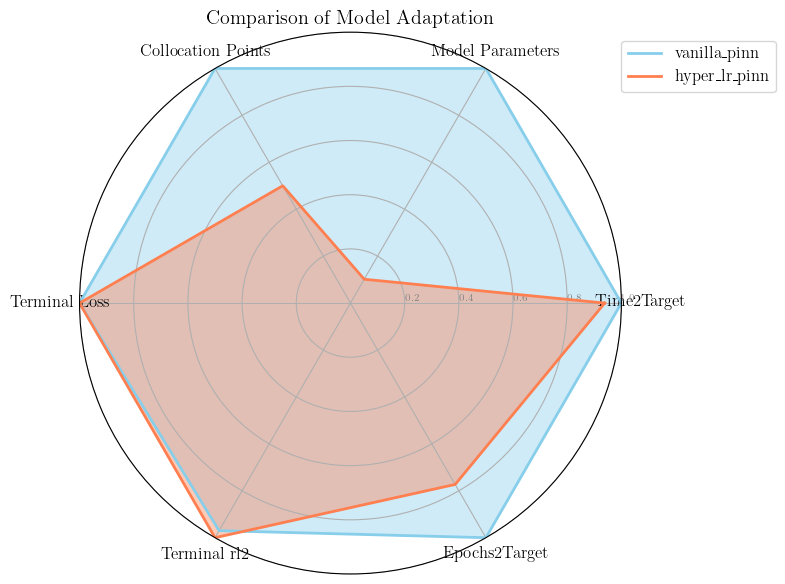

In [70]:
plot_radar_chart(inputs)